<a href="https://colab.research.google.com/github/matyusha/Harris-algorithm/blob/main/Harris.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pycuda

     |████████████████████████████████| 1.6MB 12.0MB/s 
     |████████████████████████████████| 71kB 10.5MB/s 
     |████████████████████████████████| 81kB 9.8MB/s 
  Created wheel for pycuda: filename=pycuda-2020.1-cp36-cp36m-linux_x86_64.whl size=620900 sha256=936d1f3ad1081dbb62f575f27ae1c3d29fba6a508bb917719e07a5f207ba76cc
  Stored in directory: /root/.cache/pip/wheels/8f/78/d1/5bb826f81d9d490297a348d818ff3ee6dd6f2075b06dde6ea0
  Created wheel for pytools: filename=pytools-2020.4.3-py2.py3-none-any.whl size=61374 sha256=a05b42af694b4f418a2d7366a34aa76e4e94eefbd3033b042d3a71773366a294
  Stored in directory: /root/.cache/pip/wheels/af/c7/81/a22edb90b0b09a880468b2253bb1df8e9f503337ee15432c64
Successfully built pycuda pytools


In [ ]:
import pycuda.autoinit
from pycuda.tools import make_default_context
make_default_context().get_device().name()

'Tesla T4'

In [ ]:
from string import Template
import pycuda.driver as drv
import pycuda.tools
import pycuda.autoinit
from pycuda.compiler import SourceModule
import numpy as np

def harris_gpu(img, k, thresh):
    """
    Finds and returns list of corners
        :param img: grayscale image
        :param k: Harris corner constant. Usually 0.04 - 0.06
        :param thresh: The threshold above which a corner is counted
        :return: corner_list: List with corners
        :return: average_execution_time: Average execution time in seconds
    """

    height = img.shape[0]
    width = img.shape[1]

    vector_size = img.shape[0] * img.shape[1]
    corner_list = []
    offset = 2
    # to fit still in a 32-bit integer
    thresh = int(thresh/10)

    # function template
    func_mod_template = Template("""
    #include<stdio.h>
    #define INDEX(a, b) a*${HEIGHT}+b

    __global__ void corners(
        float *dest,
        float *ixx,
        float *ixy,
        float *iyy,
        int offset,
        float k,
        int threshold) {

        unsigned int idx = threadIdx.x + threadIdx.y*blockDim.y +
                            (blockIdx.x*(blockDim.x*blockDim.y));

        unsigned int a = idx/${HEIGHT};
        unsigned int b = idx%${HEIGHT};

        float sxx = 0;
        float sxy = 0;
        float syy = 0;
        float det = 0;
        float trace = 0;
        float r = 0;

        if ((a >= offset) & (a <= (${WIDTH}-offset - 1)) &
            (b >= offset) & (b <= (${HEIGHT}-offset - 1))) {
            for (int bi = b - offset; bi < b + offset + 1; ++bi) {
                for (int ai = a - offset; ai < a + offset + 1; ++ai) {
                    sxx = sxx + ixx[INDEX(ai, bi)];
                    sxy = sxy + ixy[INDEX(ai, bi)];
                    syy = syy + iyy[INDEX(ai, bi)];
                }
            }
            det = sxx*syy - sxy*sxy;
            trace = sxx + syy;
            r = det - k*(trace*trace);
            if ((r/10) > threshold)
                dest[INDEX(a, b)] = r;
        }
    }
    """)

    func_mod = SourceModule(func_mod_template.substitute(HEIGHT=height,
                                                         WIDTH=width))
    pycuda_corners = func_mod.get_function("corners")

    # Find x and y derivatives
    dy, dx = np.gradient(img)
    Ixx = dx**2
    Ixy = dy*dx
    Iyy = dy**2

    ixx = Ixx.reshape(vector_size, order='F')
    ixy = Ixy.reshape(vector_size, order='F')
    iyy = Iyy.reshape(vector_size, order='F')
    dest_r = np.zeros_like(ixx)

    # start timer
    start = timeit.default_timer()

    pycuda_corners(drv.Out(dest_r),
                drv.In(ixx),
                drv.In(ixy),
                drv.In(iyy),
                np.uint32(offset),
                np.float32(k),
                np.uint32(thresh),
                block=(32, 32, 1),  
                grid=(height*width//1024, 1, 1))  

    # calculate used time
    execution_time = timeit.default_timer() - start

    # extract the corners
    r = np.reshape(dest_r, (height, width), order='F')
    corners = np.where(r > 0)
    for i, j in zip(corners[0], corners[1]):
        corner_list.append([j, i, r[i, j]])

    return corner_list, execution_time

Source picture:


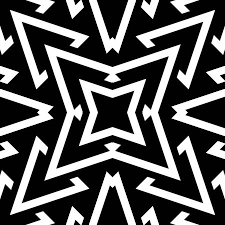

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

# load image
image = cv2.imread('/content/drive/My Drive/input.png', 0).astype(np.float32)
print('Source picture:')
cv2_imshow(image)

In [ ]:
print("Enter threshold value:")
thresh = int(input())

Enter threshold value:
3000000000


GPU result


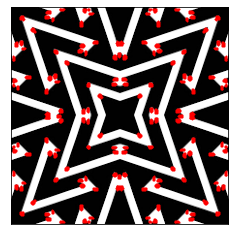

In [ ]:
import matplotlib.pyplot as plt
import timeit

k = 0.05
# run the algorithm
corners, timed = harris_gpu(image, k, thresh)

# plot the image and a red dot at the corners
print("GPU result")
n_image = np.zeros(image.shape) 
fig = plt.imshow(image, cmap='gray')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.scatter([x[0] for x in corners], [x[1] for x in corners], s=1, c = 'red')
plt.savefig('/content/drive/My Drive/output.png')
plt.show()

GPU


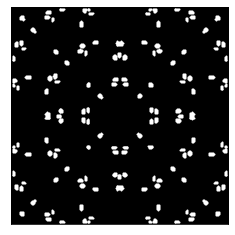

cv2.cornerHarris


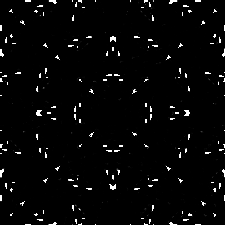

In [ ]:
print("GPU")
n_image = np.zeros(image.shape)
fig = plt.imshow(n_image, cmap='gray')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.scatter([x[0] for x in corners], [x[1] for x in corners], s=1, c = 'white')
plt.show()

print("cv2.cornerHarris")
start = timeit.default_timer()
dst = cv2.cornerHarris(image,2,3,0.05)
cv2_time = timeit.default_timer() - start
cv2_imshow(dst)

In [ ]:
print("gpu time", timed)
print("cv2.cornerHarris time", cv2_time)
print("gpu time/cv2.cornerHarris time", cv2_time/timed)

gpu time 0.0014582969997718465
cv2.cornerHarris time 0.0035586399999374407
gpu time/cv2.cornerHarris time 2.4402710836641623
